# Exercise: Deep Learning for Structured Data

In this exercise we will implement a neural network more or less from scratch using numpy for matrix operations. Clearly, we would never be doing this in practice but rather use state-of-the-art software libraries.
Still, implementing a neural network with its training routine by hand deepens our understanding and demystifies the technology.

#### Importing libraries and tools

In [1]:
!pip install numpy medmnist pandas scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import abc
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

## Utility functions

In [3]:
def plot_training_curve(loss: list, val_loss: list, fill_between=True):
    epochs_range = range(len(val_loss))
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_range, loss, label="training loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    if fill_between:
        plt.fill_between(epochs_range, loss, val_loss, color="lightpink", alpha=0.4, hatch="-", label="difference")
    plt.legend(loc="upper right")
    plt.title("training and validation loss")
    plt.show()

# Data exploration

We use the scikit-learn inbuilt breast cancer dataset. It's features are computed from digitized images of fine needle aspirates of a breast mass.
This is structured data, since it is available in a standardized tabular format.

In [4]:
df = load_breast_cancer(as_frame=True)["frame"]

The data is obtained from images such as the one below. For example, the mean radius is the average of the radi of the extracted nuclei visible in the picture.

![Image of Yaktocat](https://www.researchgate.net/profile/Nick-Street/publication/2512520/figure/fig2/AS:279373199495169@1443619169198/Snakes-After-Convergence-to-Cell-Nucleus-Boundaries-These-contours-are-the-nal.png)

Note that every good machine learning engineer should at this point check for potential issues in the data, and preprocess it as appropriate.
In this guided exercise we will completely ignore this phase; please **never** do this with real data.

For our simplified classification task, we will select the malignancy (means the cancer is not harmless) as target (already called target in our data, this is our `y`).
We will use all other columns as feature variables (our `X`).

In [5]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
X = df[list(df.columns)[:-1]].values # only first 2 columns
y = df[["target"]].values.ravel()
X.shape, y.shape

((569, 30), (569,))

Let's look at the distribution of the classes in the training dataset to see if we have a balanced dataset

In [7]:
labels = {0: "Benign", 1: "Malignant"}

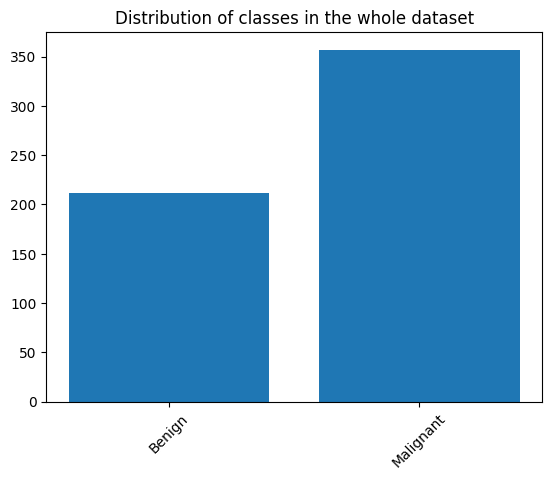

In [8]:
def count_labels(labels, classnames) -> dict:
    classnames = list(classnames)
    dictionary = dict.fromkeys(classnames, 0)
    for label in labels:
        dictionary[classnames[label]] += 1
    return dictionary


class_counts = count_labels(y.ravel(), labels.values())
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
_ = plt.title("Distribution of classes in the whole dataset")

Our goal is to create a model to predict whether an image presents malignant breast cancer.
However, we would like this model to work not only for the images in this dataset, but also for new ones captured in the future.
In other words, the model should _generalize_ well to new data.

In order to check how good our model is in predicting malignancy of yet unseen images, we put 30% of the data to the side and split this into validation and test set. The test set must only be used once for the final validation, while the validation set can be used for hyperparameter tuning.

The model will be trained only on the first 70% of the data, our _training set_. Since we have an imbalance in the data, we will use the stratify parameter to ensure that the class distribution in the splits is the same as in the original dataset.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
x_train = x_train
x_val, y_val = x_test[:len(x_test) // 2], y_test[:len(y_test) // 2]
x_test, y_test = x_test[len(x_test) // 2:], y_test[len(y_test) // 2:]
y_train, y_val, y_test = y_train.reshape(1, -1), y_val.reshape(1, -1), y_test.reshape(1, -1)
assert x_test.shape != x_val.shape or x_test != x_val
assert y_test.shape != y_val.shape or y_test != y_val

The features have very different scales, so we standardize first.

In [10]:
scaler = StandardScaler().fit(x_train)
x_train, x_val, x_test = scaler.transform(x_train).T, scaler.transform(x_val).T, scaler.transform(x_test).T

## Neural Network Implementation

In this section, we define and implement the different components of a multi-level perceptron


### Activations & Losses

In [11]:
class AbstractActivationFunction(abc.ABC):
    """
    Abstract base class for activation functions
    """

    @abc.abstractmethod
    def forward(self, z: np.ndarray):
        """
        Computes the value of the activation function element wise
        """
        ...

    @abc.abstractmethod
    def backward(self, z: np.ndarray):
        """
        Computes the derivative of the activation function element wise
        """
        ...


In [12]:
class ReLU(AbstractActivationFunction):
    """
    Implements the ReLU activation function and its derivative
    """

    def forward(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(z, 0)

    def backward(self, z: np.ndarray) -> np.ndarray:
        d = np.ones_like(z)
        d[z < 0] = 0
        return d

**Exercise 1: Implement the Sigmoid activation function and its derivative**

In [13]:
class Sigmoid(AbstractActivationFunction):
    """
    Implements the sigmoid activation function and its derivative
    """

    def forward(self, z: np.ndarray):
        """
        Computes the sigmoid function element wise
        """
        ### START YOUR CODE ###
        return 1.0 / (1.0 + np.exp(-z))
        ### END YOUR CODE ###

    def backward(self, z: np.ndarray):
        ### START YOUR CODE ###
        s = self.forward(z)
        return s * (1 - s)
        ### END YOUR CODE ###

**Click below for the solution**

In [14]:
#@title Solution for Sigmoid activation function
class Sigmoid(AbstractActivationFunction):
    """
    Implements the sigmoid activation function and its derivative
    """

    def forward(self, z: np.ndarray):
        """
        Computes the sigmoid function element wise
        """
        return 1.0 / (1.0 + np.exp(-z))

    def backward(self, z: np.ndarray):
        s = self.forward(z)
        return s * (1 - s)

In [15]:
class NormInitializer:

    def initialize_weights(self, size: int, mu: float = 0.0, sigma: float = 1.0) -> np.ndarray:
        return np.random.normal(size=size, loc=mu, scale=sigma)

    def initialize_bias(self, size: int, mu: float = 0.0, sigma: float = 1.0) -> np.ndarray:
        return np.random.normal(size=size, loc=mu, scale=sigma)

In [16]:
class AbstractLoss(abc.ABC):
    """
    Abstract base class for loss functions
    """

    def forward(self, y: np.ndarray, prob: np.ndarray) -> np.ndarray:
        """
        Computes the loss
        :param y: true labels, shape (n_classes, batch_size)
        :param prob: predicted probabilities, shape (n_classes, batch_size)
        :param class_weights: class weights for weighting loss according to class balance, shape (n_classes,)
        :return: the loss value as a float
        """
        ...

    def backward(self, y: np.ndarray, prob: np.ndarray) -> np.ndarray:
        """
        Backward pass of the loss, computes the gradient of the loss with respect to the logits
        :param y: true labels, shape (n_classes, batch_size)
        :param prob: predicted probabilities, shape (n_classes, batch_size)
        :param class_weights: class weights for weighting loss according to class balance, shape (n_classes,)
        :return: gradient of the loss with respect to the logits, shape (n_classes, batch_size)
        """
        ...

In [17]:
class BinaryCrossEntropy(AbstractLoss):
    """
    Implements the binary cross entropy loss function and its derivative
    """

    def forward(self, y: np.ndarray, prob: np.ndarray) -> float:
        """
        Computes the binary cross entropy loss
        :param y: true labels, shape (n_classes, batch_size)
        :param prob: predicted probabilities, shape (n_classes, batch_size)
        :param class_weights: class weights for weighting loss according to class balance, shape (n_classes,)
        :return: the binary cross entropy loss value as a float
        """
        assert np.max(y) <= 1, y
        assert np.max(prob) <= 1, prob
        prob = np.clip(prob, 1e-8, 1 - 1e-8)
        loss = (y * np.log(prob) + (1 - y) * np.log(1 - prob))
        return -np.mean(np.average(loss, axis=-1))

    def backward(self, y: np.ndarray, prob: np.ndarray, class_weights: np.ndarray = None) -> np.ndarray:
        """
        Backward pass of the binary cross entropy loss, computes the gradient of the loss with respect to the logits
        :param y: true labels, shape (n_classes, batch_size)
        :param prob: predicted probabilities, shape (n_classes, batch_size)
        :param class_weights: class weights for weighting loss according to class balance, shape (n_classes,)
        :return: gradient of the loss with respect to the logits, shape (n_classes, batch_size)
        """
        return -(y / (prob + 1e-8)) + ((1 - y) / (1 - prob + 1e-8))


#### Layers

In [18]:
class AbstractLayer(abc.ABC):

    def __init__(self,
                 layer_id: str,
                 n_neurons: int,
                 n_neurons_prev: int,
                 activation: AbstractActivationFunction,
                 initializer: NormInitializer) -> None:
        """
        Abstract base class for layers in an MLP
        :param layer_id: unique identifier for the layer
        :param n_neurons: number of neurons in the layer
        :param n_neurons_prev: number of neurons in the previous layer
        :param activation: activation function for the layer
        :param initializer: initializer for the weights and biases of the layer
        """
        self.layer_id = layer_id
        self.n_neurons = n_neurons
        self.n_neurons_prev = n_neurons_prev
        self.initializer = initializer
        self.activation = activation

        self.weights = None  # shape (n_neurons, n_neurons_prev)
        self.bias = None  # shape (n_neurons, 1)
        self.logits = None  # shape (n_neurons, batch_size)
        self.activations = None  # shape(n_neurons, batch_size)
        self.grad_logits = None  # shape(n_neurons, batch_size)

    def initialize(self) -> None:
        """
        Initializes the weights and biases of the layer
        """
        sigma_w = np.sqrt(2.0 / (self.n_neurons + self.n_neurons_prev))  # suited for sigmoid activation function
        sigma_b = np.sqrt(1.0 / self.n_neurons)
        self.weights = self.initializer.initialize_weights(size=(self.n_neurons, self.n_neurons_prev), mu=0.0,
                                                           sigma=sigma_w)
        self.bias = self.initializer.initialize_bias(size=(self.n_neurons, 1), mu=0.0, sigma=sigma_b)

    @abc.abstractmethod
    def forward(self, activations_prev: np.ndarray) -> np.ndarray:
        """
        Forward pass of the layer, computes the logits and activations of the layer
        :param activations_prev: activations of the previous layer, shape (n_neurons_prev, batch_size)
        :return: activations of the layer, shape (n_neurons, batch_size)
        """
        ...

    @abc.abstractmethod
    def backward(self, grad_activations: np.ndarray) -> np.ndarray:
        """
        Backward pass of the layer, computes the gradient with respect to the activations of the previous layer
        :param grad_activations: gradient with respect to the activations of the current layer, shape (n_neurons, batch_size)
        """
        ...

    def gradient_weights(self, activations_prev: np.ndarray) -> np.ndarray:
        """
        Gradient of the loss with respect to the weights of the layer
        :param activations_prev: activations of the previous layer, shape (n_neurons_prev, batch_size)
        :return: gradient of the loss with respect to the weights, shape (n_neurons, n_neurons_prev)
        """
        grad_weights = self.grad_logits.dot(activations_prev.T)
        return grad_weights

    def gradient_bias(self) -> np.ndarray:
        """
        Gradient of the loss with respect to the bias of the layer
        :return: gradient of the loss with respect to the bias, shape (n_neurons, 1)
        """
        grad_bias = self.grad_logits.sum(axis=-1, keepdims=True)
        return grad_bias

**Exercise 2: Forward and backward propagation of layers**

In [19]:
class Layer(AbstractLayer):

    def forward(self, activations_prev: np.ndarray) -> np.ndarray:
        """
        Forward pass of the layer, computes the logits and activations of the layer
        :param activations_prev: activations of the previous layer, shape (n_neurons_prev, batch_size)
        :return: activations of the layer, shape (n_neurons, batch_size)
        """
        np.testing.assert_equal(activations_prev.shape[0], self.n_neurons_prev)

        ### START YOUR CODE ###
        self.logits = np.dot(self.weights, activations_prev) + self.bias
        self.activations = self.activation.forward(self.logits)

        return self.activations
        ### END YOUR CODE ###

    def backward(self, grad_activations: np.ndarray) -> np.ndarray:
        """
        Backward pass of the layer, computes the gradient with respect to the activations of the previous layer
        :param grad_activations: gradient with respect to the activations of the current layer, shape (n_neurons, batch_size)
        """
        n_samples = self.logits.shape[1]
        np.testing.assert_equal(grad_activations.shape, (self.n_neurons, n_samples))

        ### START YOUR CODE ###
        # Compute gradient with respect to logits
        self.grad_logits = grad_activations * self.activation.backward(self.logits)
        np.testing.assert_equal(self.grad_logits.shape, (self.n_neurons, nsamples))

        # Compute gradient with respect to previous layer activations
        grad_activations_prev = self.weights.T.dot(self.grad_logits)
        np.testing.assert_equal(grad_activations_prev.shape, (self.n_neurons_prev, nsamples))

        return grad_activations_prev
        ### END YOUR CODE ###

**Click below for the solution**

In [20]:
#@title Solution for Layer forward and backward propagation
class Layer(AbstractLayer):

    def forward(self, activations_prev: np.ndarray) -> np.ndarray:
        """
        Forward pass of the layer, computes the logits and activations of the layer
        :param activations_prev: activations of the previous layer, shape (n_neurons_prev, batch_size)
        :return: activations of the layer, shape (n_neurons, batch_size)
        """
        np.testing.assert_equal(activations_prev.shape[0], self.n_neurons_prev)

        ### START YOUR CODE ###
        self.logits = np.dot(self.weights, activations_prev) + self.bias
        self.activations = self.activation.forward(self.logits)

        return self.activations
        ### END YOUR CODE ###

    def backward(self, grad_activations: np.ndarray) -> np.ndarray:
        """
        Backward pass of the layer, computes the gradient with respect to the activations of the previous layer
        :param grad_activations: gradient with respect to the activations of the current layer, shape (n_neurons, batch_size)
        """
        nsamples = self.logits.shape[1]
        np.testing.assert_equal(grad_activations.shape, (self.n_neurons, nsamples))

        # Compute gradient with respect to logits
        self.grad_logits = grad_activations * self.activation.backward(self.logits)
        np.testing.assert_equal(self.grad_logits.shape, (self.n_neurons, nsamples))

        # Compute gradient with respect to previous layer activations
        grad_activations_prev = self.weights.T.dot(self.grad_logits)
        np.testing.assert_equal(grad_activations_prev.shape, (self.n_neurons_prev, nsamples))

        return grad_activations_prev

#### MLP

In [21]:
class AbstractMultiLayerPerceptron(abc.ABC):

    def __init__(self,
                 neurons_per_layer: list[int],
                 activation: AbstractActivationFunction,
                 initializer: NormInitializer) -> None:
        """
        Abstract base class for a multi layer perceptron
        :param neurons_per_layer: list of integers, number of neurons per layer
        :param activation: activation function for the hidden layers
        :param initializer: initializer for the weights and biases of the layers
        """
        self.layers = []  # list of layers (instances of class Layer or Softmax or the like); ordered along the forward path.
        self.number_layers = -1  # number of layers (excluding input layer, excluding softmax layer)
        self.x = None  # input data for one iteration (forward and backward)

        self.number_layers = len(neurons_per_layer)

        for layer_id in range(1, self.number_layers):
            if layer_id != self.number_layers - 1:
                layer_act = activation
            else:
                layer_act = Sigmoid()
            n_neurons = neurons_per_layer[layer_id]
            n_neurons_prev = neurons_per_layer[layer_id - 1]
            self.layers.append(
                Layer(
                    layer_id, n_neurons, n_neurons_prev,
                    layer_act, initializer))

    def initialize(self) -> None:
        """
        Initializes the weights and biases of the layers
        """
        for layer in self.layers:
            layer.initialize()

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass of the MLP
        :param x: input data, shape (n_features, batch_size)
        :return: output of the MLP, shape (n_classes, batch_size)
        """
        self.x = x
        a = self.x

        for layer in self.layers:
            a = layer.forward(a)

        return a

    def backward(self, grady: np.ndarray) -> np.ndarray:
        """
        Backward pass of the MLP to compute the gradients
        :param grady: gradient of the loss with respect to the output of the MLP, shape (n_classes, batch_size)
        :return: gradient of the loss with respect to the input of the MLP, shape (n_features, batch_size)
        """
        grad = grady

        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    @abc.abstractmethod
    def step_params(self, learning_rate: float) -> None:
        """
        Updates the parameters of the MLP
        :param learning_rate: learning rate for the parameter update
        """
        ...


**Exercise 3: Implement the parameter update step for the MLP**

In [22]:
class MultiLayerPerceptron(AbstractMultiLayerPerceptron):
    def step_params(self, learning_rate: float) -> None:
        """
        Updates the parameters of the MLP
        :param learning_rate: learning rate for the parameter update
        """
        ### START YOUR CODE ###
        prev_activations = self.x

        for layer in self.layers:
            layer.weights -= learning_rate * layer.gradient_weights(prev_activations)
            layer.bias -= learning_rate * layer.gradient_bias()

            prev_activations = layer.activations
        ### END YOUR CODE ###

**Click below for the solution**

In [23]:
#@title Solution for the parameter update step of the MLP
class MultiLayerPerceptron(AbstractMultiLayerPerceptron):
    def step_params(self, learning_rate: float) -> None:
        """
        Updates the parameters of the MLP
        :param learning_rate: learning rate for the parameter update
        """
        ### START YOUR CODE ###
        prev_activations = self.x

        for layer in self.layers:
            layer.weights -= learning_rate * layer.gradient_weights(prev_activations)
            layer.bias -= learning_rate * layer.gradient_bias()

            prev_activations = layer.activations
        ### END YOUR CODE ###

### Forward Test

If your implementation is incorrect, this should throw an AssertionError.

In [24]:
x = np.arange(9).reshape(3, 3).astype(float)
layer_sizes = [3, 16, 16, 1]
np.random.seed(42)

mlp = MultiLayerPerceptron(layer_sizes, Sigmoid(), NormInitializer())
for layer_id in range(len(layer_sizes) - 1):
    layer = mlp.layers[layer_id]
    layer.weights = np.ones(shape=(layer.n_neurons, layer.n_neurons_prev), dtype='float') * 0.1
    layer.bias = np.zeros(shape=(layer.n_neurons_prev, 1), dtype='float')

mlp.initialize()
y = mlp.forward(x)
np.testing.assert_equal(y.shape, (1, 3))

y_expected = np.array([[0.54265 , 0.541717, 0.540696]])
np.testing.assert_array_almost_equal(y, y_expected, decimal=6)

### Gradient Checking

Of course plotting the gradient gives us immediate insights whether our gradient makes sense, but it's hard to tell when the gradient is just slightly off.

In [25]:
bce = BinaryCrossEntropy()
sigmoid = Sigmoid()

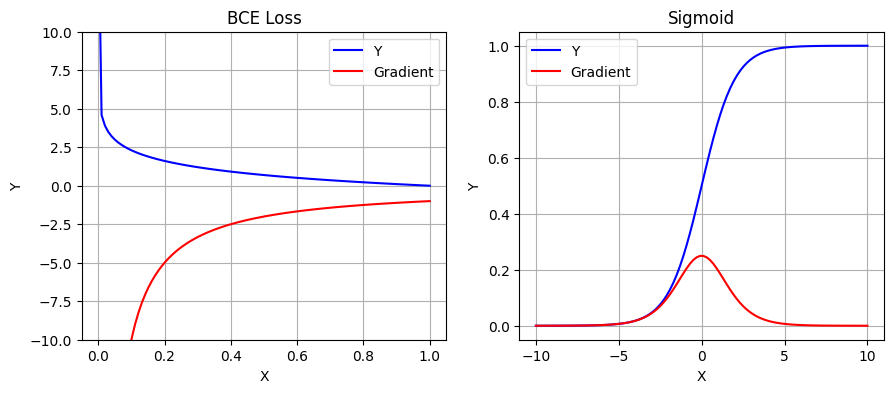

In [26]:
p_values = np.linspace(0.00, 1, 100)
values = np.linspace(-10, 10, 100)
positive = np.array([[1]])
negative = np.array([[0]])

bce_y1 = [bce.forward(positive, np.array([[p]])) for p in p_values]
bce_grad_1 = [np.mean(bce.backward(positive, np.array([[p]]))) for p in p_values]

sig_y1 = [sigmoid.forward(v) for v in values]
sig_grad_1 = [sigmoid.backward(v) for v in values]

def show_gradient(x: np.ndarray, y, grad: np.ndarray, title: str, idx: int, y_lim=None) :
    plt.subplot(1, 3, idx)
    plt.plot(x, y, label="Y", color='blue')
    plt.plot(x, grad, label="Gradient", color='red')
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.grid(True)
    plt.legend()

plt.figure(figsize=(16, 4))
show_gradient(p_values, bce_y1, bce_grad_1, title="BCE Loss", idx=1, y_lim=(-10, 10))
show_gradient(values, sig_y1, sig_grad_1, title="Sigmoid", idx=2)

 We can also check the gradient numerically with the finite differences method.

Checking the cross-entropy loss gradient

In [27]:
np.random.seed(42)
epsilon = 1e-8
tolerance = 1e-7

y_pred = np.random.uniform(0.0, 1.0, (1, 16))
y_true = (np.random.uniform(0.0, 1.0, (1, 16)) > 0.5).astype(float)

loss = bce.forward(y_true, y_pred)
grad_analytical = bce.backward(y_true, y_pred)

predictions_plus = y_pred + epsilon
predictions_minus = y_pred - epsilon

loss_plus = bce.forward(y_true, predictions_plus)
loss_minus = bce.forward(y_true, predictions_minus)

grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)

print(f"Measured Error: {np.mean(grad_analytical) - grad_numerical}")
assert abs(np.mean(grad_analytical) - grad_numerical) < tolerance
print("Gradient check passed")

Measured Error: -7.155516235091142e-09
Gradient check passed


Checking the Sigmoid gradient

In [28]:
np.random.seed(42)
epsilon = 1e-8
tolerance = 1e-7

sigmoid = Sigmoid()
y_pred = np.random.uniform(-10, 10.0, (1, 16))

loss = sigmoid.forward(y_pred)
grad_analytical = sigmoid.backward(y_pred)

predictions_plus = y_pred + epsilon
predictions_minus = y_pred - epsilon

loss_plus = sigmoid.forward(predictions_plus)
loss_minus = sigmoid.forward(predictions_minus)

grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)

print(f"Measured Error: {grad_analytical - grad_numerical}")
assert abs(np.mean(grad_analytical - grad_numerical)) < tolerance
print("Gradient check passed")

Measured Error: [[-2.13093071e-10 -1.18926436e-08 -1.03649139e-08 -8.79888523e-11
   6.25263079e-12  3.55093472e-12 -1.05924403e-11  7.45136706e-09
   1.71717753e-09 -4.10746829e-09 -5.15359940e-12  9.22051539e-09
  -3.55145578e-09  3.27058719e-11  5.38106018e-13  3.69823334e-12]]
Gradient check passed


In [29]:
tolerance = 3e-7
epsilon = 1e-8
np.random.seed(41)

layer_sizes = [16, 16, 1]
mlp_0 = MultiLayerPerceptron(neurons_per_layer=layer_sizes, initializer=NormInitializer(), activation=Sigmoid())
mlp_1 = MultiLayerPerceptron(neurons_per_layer=layer_sizes, initializer=NormInitializer(), activation=Sigmoid())
mlp_0.initialize()
mlp_1.initialize()

for layer_id in range(len(layer_sizes) - 1):
    mlp_1.layers[layer_id].weights = mlp_0.layers[layer_id].weights.copy()
    mlp_1.layers[layer_id].bias = mlp_0.layers[layer_id].bias.copy()

batch_size = 16
x = np.random.uniform(-0.5, 0.5, size=(layer_sizes[0], batch_size))
y = np.random.uniform(0, 1, size=(1, batch_size))

probs = mlp_0.forward(x)
grad = bce.backward(y, probs)
mlp_0.backward(grad)

for layer_id in range(len(layer_sizes) - 1):
    print("Testing layer with id %s" % layer_id)
    if layer_id == 0:
        activations_prev = x
    else:
        activations_prev = mlp_0.layers[layer_id - 1].activations
    for i in range(layer_sizes[layer_id + 1]):
        for j in range(layer_sizes[layer_id]):
            mlp_1.layers[layer_id].weights[i, j] += epsilon
            probs_plus = mlp_1.forward(x)

            mlp_1.layers[layer_id].weights[i, j] -= 2 * epsilon
            probs_minus = mlp_1.forward(x)

            loss_plus = bce.forward(y, probs_plus)
            loss_minus = bce.forward(y, probs_minus)

            numeric_gradient = (loss_plus - loss_minus) / (2 * epsilon)
            analytic_gradient = mlp_0.layers[layer_id].gradient_weights(activations_prev)[i, j] / batch_size
            d = np.abs(numeric_gradient - analytic_gradient)

            assert d <= tolerance, f"Gradient check failed for layer {layer_id}, parameter index {i, j}: {d} > {tolerance}"

            mlp_1.layers[layer_id].weights[i, j] += epsilon


Testing layer with id 0
Testing layer with id 1


### Training

Finally, lets prepare the data for training

Now we can train the model, first we have to define the hyperparameters

In [30]:
x_shape = x_train[:, 0].shape[0]
learning_rate = 5e-3
batch_size = 16
batches = int(np.ceil(x_train.shape[0] / batch_size))
epochs = 100
layer_sizes = [x_shape, 128, 128, 1]
layer_sizes

[30, 128, 128, 1]

In [31]:
mlp = MultiLayerPerceptron(layer_sizes, ReLU(), NormInitializer())
mlp.initialize()
bce = BinaryCrossEntropy()

**Exercise 4: Implement the training step**

In [32]:
def training_step(mlp: MultiLayerPerceptron,
                  loss: BinaryCrossEntropy,
                  x_batch: np.ndarray,
                  y_batch: np.ndarray) -> float:
    """
    Trains the network for one batch of data
    :param mlp: the multi-layer perceptron instance
    :param loss: the loss function instance
    :param x_batch: the input data
    :param y_batch: the labels
    :return:
    """
    ### START YOUR CODE ###
    probs = mlp.forward(x_batch)
    grad_loss = loss.backward(y_batch, probs)
    mlp.backward(grad_loss)
    mlp.step_params(learning_rate)
    return bce.forward(y, probs)
    ### END YOUR CODE ###

**Click below for the solution**

In [33]:
#@title Solution for the training step
def training_step(mlp: MultiLayerPerceptron,
                  loss: BinaryCrossEntropy,
                  x_batch: np.ndarray,
                  y_batch: np.ndarray) -> float:
    """
    Trains the network for one batch of data
    :param mlp: the multi-layer perceptron instance
    :param loss: the loss function instance
    :param x_batch: the input data
    :param y_batch: the labels
    :return: the loss for the batch
    """
    ### START YOUR CODE ###
    probs = mlp.forward(x_batch)
    grad_loss = loss.backward(y_batch, probs)
    mlp.backward(grad_loss)
    mlp.step_params(learning_rate)
    return bce.forward(y, probs)
    ### END YOUR CODE ###

In [34]:
x_train.shape, y_train.shape

((30, 398), (1, 398))

Now we write out the training loop. We will store the training and validation losses for each epoch and plot them afterwards.

In [35]:
np.random.seed(42)
train_losses = []
val_losses = []

# loop over the epochs and the mini-batches, update the parameters and fill the values for the learning curves
start = timer()
mlp.initialize()

progress = tqdm(range(epochs), desc="Training MLP")
for epoch in progress:

    epoch_losses = []
    for batch in range(batches):
        batch_start, batch_end = batch * batch_size, (batch + 1) * batch_size
        batch_end = min(batch_end, x_train.shape[1])
        if batch_end - batch_start < 1:
            continue
        x = x_train[:, batch_start:batch_end]
        y = y_train[:, batch_start:batch_end]

        loss = training_step(mlp, bce, x, y)
        epoch_losses.append(loss)

    train_losses.append(np.mean(epoch_losses))
    pred_probs = mlp.forward(x_val)
    val_loss = bce.forward(y_val, pred_probs)
    val_losses.append(val_loss)
    progress.set_postfix(epoch=epoch, train_loss=train_losses[-1], val_loss=val_losses[-1], refresh=True)

Training MLP:   0%|          | 0/100 [00:00<?, ?it/s]

The validation curve

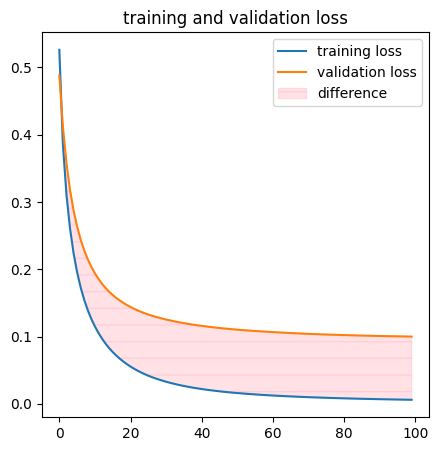

In [36]:
plot_training_curve(train_losses, val_losses)

In [37]:
def predict(mlp: MultiLayerPerceptron, inference_data: np.ndarray) -> np.ndarray:
    pred: np.ndarray = mlp.forward(inference_data)
    return (pred > 0.5).astype(int)

In [38]:
y_pred = predict(mlp, x_test)

Let's look at the performance on the test data, we can use scikit-learns built in utilities for this.

In [39]:
report = classification_report(
    y_test.flatten(),
    y_pred.flatten(),
    target_names=list(labels.values()),
    zero_division=0,
    output_dict=True
)

print(f"Accuracy: {report['accuracy']}")
metrics = {k: v for k, v in report.items() if k not in ['accuracy']}
df_report = pd.DataFrame(metrics).transpose()
df_report = df_report[['precision', 'recall', 'f1-score', 'support']].round(4)
df_report

Accuracy: 0.9069767441860465


,precision,recall,f1-score,support
Benign,0.9286,0.8125,0.8667,32.0
Malignant,0.8966,0.9630,0.9286,54.0
macro avg,0.9126,0.8877,0.8976,86.0
weighted avg,0.9085,0.9070,0.9055,86.0


With the confusion matrix, we can see where the errors were made. In total, we only missclassified 8 samples on the test set, pretty good!

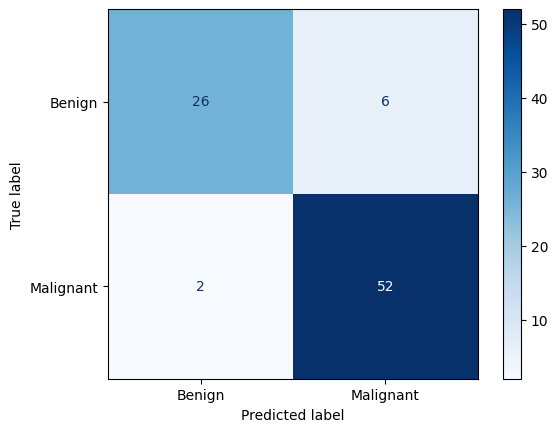

In [40]:
matrix = confusion_matrix(y_test.ravel(), y_pred.ravel())

ConfusionMatrixDisplay(matrix, display_labels=list(labels.values())).plot(cmap=plt.cm.Blues)
tick_marks = np.arange(len(list(labels.values())))
plt.xticks(tick_marks, list(labels.values()))
_ = plt.yticks(tick_marks, list(labels.values()))